## Урок 2: Построение надежной локальной валидации

* описание проблем локальной валидации;
* последствий построения ненадежной валидации;
* стратегии валидации: hold-out валидация, kfold-валидация, groupkfold-валидация, adversarial-валидация
* построение доверительных интервалов для оценки надежности валидации
* сравнение моделей при шумных результатах кросс-валидации
* стратегии выбора схемы валидации
* валидация для задач с временной структурой в данных

## Важность локальной валидации

Нередко, в соревнованиях мы видим, как люди прыгают вниз по лидерборду после раскрытия приватного лидерборда. У нас может возникнуть вопрос, __что произошло?__ У таких скачков есть 2 основные причины: 

* участники соревнования не очень доверяли своей локальной валидации и выбрали финальные решения, основываясь на их  производительности на публичном лидерборде, то есть они выбрали наилучшие решения по публичному лидерборду;

* иногда в соревнованиях разбиение на приватную и публичную часть лидерборда произведено неконсистентно:

    * распределение на публичной и приватной части лидерборда отличаются;
    * разбиение проведено неслучайным образом;
    * разбиение проведено так, что публичная или приватная часть лидерборда состоит очень маленького объема, что делает оценки на этой выборке несостоятельными / нерепрезентативными.
    
Со второй проблемой, мы как участники, не можем ничего сделать, так как этот вопрос лежит на совести организаторов соревнования. Но, мы определенно, можем убедиться, что выбрали наиболее подходящее решение для финального выбора. Итак, __цель сегодняшней лекции__ - систематизировать способы настройки валидации на соревновании и решения наиболее распространенных проблем, связанных с локальной валидацией. 

Давайте теперь поговорим об общей концепции валидации, это одна из ключевых проблем во всем машинном обучении, поэтому имеет смысл поговорить о ней детально. Если говорить коротко, то мы хотим проверить, __работает ли модель так же качественно на новых, ранее невидимых данных__. Например, если мы решаем задачу из медицины: мы хотим определить вероятность диагностирования определенного заболевания у пациента в ближайшем будущем. Мы должны быть уверены, что модель, которую мы построили, будет применима в будущем. И не только применима, мы должны быть уверены в качестве, с которым модель работает и в количестве ошибок каждого типа, которые модель допускает. Проблема заключается в том, что качество модели может отличаться на обучающих данных, которые являются историческими, и на невидимых тестовых данных из будущего. При этом, модель может запомнить всех пациентов из обучающих данных, хорошо работать на обучающих данных, но быть совершенно бесполезной на тестовых данных. Мы хотим избегать таких ситуация :) Мы хотим, чтобы модель могла выявить закономернности в данных, которые хорошо обобщаются как на обучающей выборке, так и на валидационной выборке, и на тестовой выборке. Давайте разберем этот процесс с точки зрения недооюучения модели и переобучения модели. Рассмотрим эту концепцию, на примере задачи бинарной классификации: здесь на левом рисунке мы видим слишком простую модель, которая не может уловить закономернности в данных, и мы получаем __плохие результаты на всех выборках__. Такая ситуация называется __недообучением__. Если качество модели плохое на всех выборках, то нужно увеличить сложность модели. Если мы сделаем модель слишком сложной, как на картинке справа, она начнет описывать шум из обучающих данных, которые не обощаются на тестовые данные. Это приведет к снижению качества модели. Такая ситуация называется __переобучением__. Переобученная модель обеспечивает высокую точность на обучающих данных, но плохие результаты на новых данных. Такая модель бесполезна в реальном мире и в соревнованиях, так как не может предсказать результаты для новых случаев. Таким образом, мы хотим получить что-то среднее между переобучением и недообучением, но для этого нам важно иметь возможность корректно оценивать наши результаты. 

<img src="images/web2_fit.png" width=800 height=600 />

__Важное замечание!__ Переобучение в машинном обучении (в целом) и переобучение в соревнованиях по анализу данных немного отличаются. В общем, мы говорим, что модель переобучена, если значение метрики качества на обучающих данных значимо лучше, чем на тестовых данных. Но в соревнованиях, мы часто говорим, что модели переобучаются только в том случае, если качество на лидерборде будет хуже, чем мы ожидали (чем на локальной валидации). 

__Пример:__ мы используем __модель градиетного бустинга на основе решающих деревьев__ для решения соревнования, целевая метрика - ROC-AUC. Часто мы можем наблюдать, что качество на обучающих данных __близко к 1__, тогда как на тестовых данных оно может быть меньше, например, __0.9__. В общем смысле, модель здесь переобучена, но в контексте соревнования, если __ROC-AUC = 0.9__ как на тестовых данных, так и на публичной части лидерборда, мы не можем говорить, что модель переобучена. Но только в контексте соревнования по анализу данных, для промышленной модели разница в метриках слишком большая, имеет смысл сделать модель менее сложной.

In [86]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [68]:
data = pd.read_csv("data/mercedes-benz-greener-manufacturing/train.csv")
data.head(n=2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0


## Hold-Out валидация (валидация на отложенной выборке)

Итак, начнем, говорить о валидации более предметно :)
Самая простая стратегия, которую мы можем использовать, это разделить данные на две части: для обучения и для проверки. Наша задача заключается в том, чтобы подобрать __репрезентативное разбиение__, которое максимально совпадало бы с тестовыми данными / данными из будущего, и настроить модель на хорошую работу на обучающей / на проверочной выборке. __Качественной и устойчивой валидацией__ считается валидация, при которой значение метрики качества на проверочной выборке и на лидерборде __близко совпадают__. __ВАЖНО__, что один объект может идти либо в обучающую выборку, либо в тестовую выборку, таким образом выборки не должны пересекаться. В противном случае, мы не можем доверять нашей валидации. Иногда это случается, если в данных есть зависимые наблюдения. __Примером зависимых наблюдений__ может являться задача обнаружения мошеннических транзакций, транзакции привязаны к определенному клиенту, один клиент может совершать много транзакций, транзакции одного клиента являются зависимыми наблюдениями. Если связанные наблюдения попали в разные выборки, то мы получим более точные прогнозы на таких объектах и более оптимистические оценки качества в целом, что может помешать нам выбрать лучшую модель. Кроме того, оценки качества модели в таком случае, сильно зависит от разбиения и от того, сколько связанных объектов попало в выборку для валидации.

<img src="images/web2_holdout_2sample.png" width=600 height=300 />


In [69]:
x_train, x_test = train_test_split(
    data.drop(["ID", "y"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    data["y"], train_size=0.75, shuffle=True, random_state=1,
)

In [70]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 3156 rows, 368 cols
x_test.shape = 1053 rows, 368 cols


In [5]:
model = xgb.XGBRegressor(random_state=1)
model.fit(x_train, y_train)

[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# недообучение -
# переобучение +
# все ок =

In [71]:
train_score = r2_score(y_train, model.predict(x_train))
test_score = r2_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.586, Test-score: 0.628


После того, как мы зафиксируем разбиение, мы строим модели и неоднократно проверяем качество модели на валидационном наборе данных, некоторые модели, в силу случайности, будут иметь более высокие результаты, чем другие. Если мы продолжим отбирать лучшие модели, модифицировать их и сновать выбирать лучшие модели, мы будем видеть постоянное улучшение метрики качества. Но это не означает, что модель действительно стала лучше, и мы увидим улучшения метрики качества на лидерборде. Используя такой подход, мы можем подогнаться под валидационнй набор данных, и публичный лидерборд, а потом откатиться назад на приватной части лидерборда. Это называется __переобучением на соревнованиях__.

<img src="images/web2_holdout_3sample.png" width=600 height=300 />

Представим, что мы работаем с данными объемом 5000 строк. При использовании Hold-Out валидации нам нужно решить, сколько строк попадет в обучающий набор, а сколько - в тестовый. Чем больше набор для тестирования, тем надежнее будут оценки качества и тем выше вероятность, что мы выберем наиболее оптимальную модель. Обычно мы оставляем около 20% наблюдений в тестовой части, но даже имея 1000 наблюдений в тестовой части, мы можем столкнуться с некоторой случайностью при интерпретации результатов. Модель может хорошо работать с одним набором из 1000 наблюдений, при этом быть неточной для другой 1000 наблюдений. Таким образом, чем более объемный тестовый набор данных, тем меньше эффект случайности в получаемых значениях метрики качества. С другой стороны, мы можем получить большой тестовый набор, только удалив данные из обучающего набора, а чем меньше набор данных для обучения - тем слабее модели. 


In [7]:
x_train, x_valid = train_test_split(
    data.drop(["ID", "y"], axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["y"], train_size=0.7, shuffle=True, random_state=1,
)

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 2946 rows, 368 cols
x_valid.shape = 884 rows, 368 cols
x_test.shape = 379 rows, 368 cols


In [8]:
model = xgb.XGBRegressor(random_state=1)
model.fit(x_train, y_train)

[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [9]:
train_score = r2_score(y_train, model.predict(x_train))
valid_score = r2_score(y_valid, model.predict(x_valid))
test_score = r2_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.594, Valid-score: 0.609, Test-score: 0.613


## Bootstrap

Цель анализа данных, как и валидации - получить __максимально точные выборочные оценки__ и распространить результаты на всю генеральную совокупность. При этом, в реальном мире, мы работает с выборками конечного объема, и на этой выборке можем вычислить выборочные статистики, примерами которых являются среднее, медиана, precision, recall, ROC-AUC и другие. Значение каждой из выборочных статистик будет меняться от выборки к выборке, и мы хотели бы знать размер этих отклонений в зависимости от популяции. Один из подходов к оценке таких отклонений - техника бутстрепа, которая заключается в извлечении данных из имеющейся выборки случайным образом и вычисление целевой метрики по таким фиктивным выборкам с целью определить выборочные распределение статистики. Таким образом, мы анализируем большое число "фантомных" выборок, которые называются бутстреп-выборками. Обычно, случайным образом генерируется несколько тысяч таких выборок, из этих выборок можно найти бутстреп-распределение интересующей нас статистики. 

Бустреп-выборки генерируются случайным выбором с возвращением, выбранные элементы исходной выборки возвращаются в выборку и могут быть выбраны повторно. Формально, на каждом шаге мы выбираем элемент исходной выборки с вероятностью $\frac{1}{n}$. Таким способ мы строим несколько сотен / тысяч выборок, далее мы можем построить эмпирическую функцию распределеня оценок, посчитать квантили и доверительные интервалы.




In [83]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [85]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), r2_score)

calculate_confidence_interval(scores)

(0.5669246917381529, 0.6815522034849284)

In [ ]:
# Hold-Out
# оценил качество на HO
# доверительный интервал на HO
# отправляю решение на LB
# если качество на public LB лежит внутри CI -> валидация хорошая

Text(0.5, 0, 'sampel number')

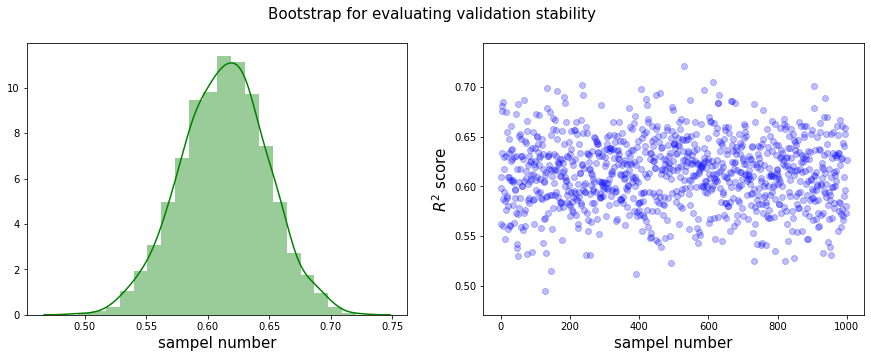

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

## KFold валидация

Рассмотрим вторую стратегию валидации, которая называется __K-Fold__, этот вид можно рассматривать как повторную Hold-Out валидацию, потому что мы разбиваем данные на несколько непересекающихся блоков, используя каждый блок как тестовую выборку только один раз. После этой процедуры мы можем посчитать среднее метрики качества по всем блокам, а также дисперсию метрики качества. Здесь важно остановится на разнице между K-Fold и несколькими Hold-Out валидациями. Если мы сделаем несколько независимых Hold-Out валидаций, мы также можем получить K различных оценок, но некоторые наблюдения могут никогда не попасть в валидационную выборку, а некоторые наблюдения могут быть использованы несколько раз. В то же время, основное преимущество K-Fold валидации состоит в том, что мы используем каждый независимый блок для проверки только один раз. Этот метод валидации - хороший выбор, когда у нас есть относительно небольшой объем данных, и мы можем получить достаточно большое отличие в качестве на каждом блоке.

<img src="images/web2_kfold.png" width=800 height=600 />

__Как определить значение $K$?__
Значение $K$ выбирается таким образом, чтобы каждая обучающая / тестовая группа данных была достаточно большой, чтобы быть статистически репрезентативной пот отношению к исходному датасету. Значение $K$ = 10 очень распространено в области прикладного машинного обучения и рекомендуется, если вы пытаетесь выбрать значение для своего набора данных. Обычно, чем выше $K$, тем более высокое качество мы можем получить, в силу того, что лагориты обучаются на более крупном наборе данных. Также хорошим стартом будет $K$ = 5.


In [13]:
cv = cross_val_score(
    estimator=model,
    X=data[numerical_features],
    y=data["y"],
    scoring="r2",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV-results: 0.5654 +/- 0.069


In [14]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [15]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data[numerical_features], data["y"], model, metric=r2_score, cv_strategy=cv_strategy
)

[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 1, train-observations = 3367, valid-observations = 842
train-score = 0.5888, valid-score = 0.6157
[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 2, train-observations = 3367, valid-observations = 842
train-score = 0.6491, valid-score = 0.4396
[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 3, train-observations = 3367, valid-observations = 842
train-score = 0.6017, valid-score = 0.5898
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 4, train-observations = 3367, valid-observations = 842
train-score = 0.6094, valid-score = 0.5497
[18:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold

## Stratified KFold валидация

Способ валидации очень похожий на KFold, только с небольшим дополнением. Разделение данных на фолды происходит так, чтобы в каждом фолде было одинаковое распределение целевой переменной. Такой подход полезен, если у нас слишком мало данных для обучения модели, а также для сильно несбалансированных наборов данных для задачи классификации. Кроме того, такой подход полезен при решении задачи многоклассовой классификации с очень большим количество классов.

<img src="images/web2_stratified_kfold.png" width=800 height=600 />


## Trade-Off между Hold-Out и CV

Кросс-валидация дает более точную оценку качества модели, что особенно важно, если мы принимаем множество решений по моделированию: 

* как обработать выбросы;
* как заполнить пропуски;
* какие признаки использовать при обучении;
* какой тип алгоритмов использовать;
* какой набор гиперпараметров использовать.

Однако запуск кросс-валидации может занять больше времени. Учитывая эти компромиссы, когда следует использовать каждый подход? Для небольших наборов данных дополнительная вычислительная нагрузка при выполнении кросс-валидации не имеет большого значения. На маленьких датасетах качество может сильно варьироваться в зависимости от разбиения данных. Итак, если __набор данных маленький__, то следует использовать __кросс-валидацию__.

По тем же причинам для больших наборов данных достаточно использовать Hold-Out. Он будет работать быстрее, и у вас может быть достаточно данных, поэтому нет необходимости повторно использовать некоторые из них для повторного тестирования. Проблема в том, что не существует простого порогового значения для определения большого и маленького набора данных. Если для обучения вашей модели требуется пара минут или меньше, вероятно, стоит перейти на кросс-валидацию. Если обучение вашей модели занимает гораздо больше времени, кросс-валидация может замедлить рабочий процесс. Кроме того, вы можете запустить кросс-валидацию в начале работы надо задачей и посмотреть, близки ли оценки для каждого фолда. Если каждый эксперимент дает одинаковые результаты, вероятно, достаточно разделить данные на обучение / тест.

## Что делать, если результаты кросс-валидации неустойчивые?

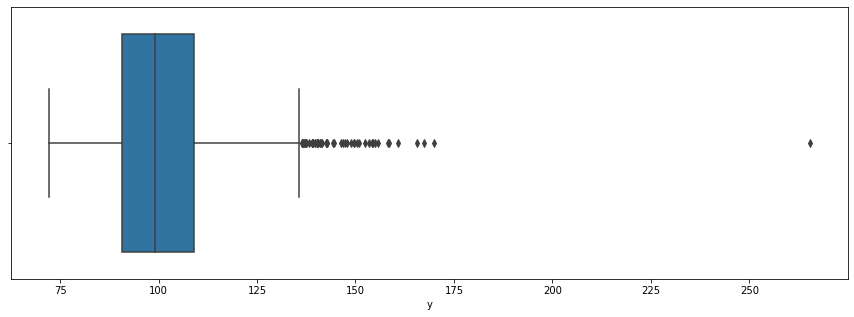

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.boxplot(data["y"], ax=axes)

In [ ]:
# постановка задачи
# модель 1 - RF
# модель 2 - XGB
# 

In [87]:
cv_rf = cross_val_score(
    estimator=RandomForestRegressor(n_estimators=25, max_depth=8, random_state=27, n_jobs=-1),
    X=data[numerical_features], y=data["y"], scoring="r2", cv=5
)
print(cv_rf)
print(f"CV-mean: {round(np.mean(cv_rf), 4)}, CV-std: {round(np.std(cv_rf), 4)}")

[0.59717674 0.42730924 0.58603809 0.54180877 0.62831393]
CV-mean: 0.5561, CV-std: 0.0701


In [20]:
cv = cross_val_score(
    estimator=model, X=data[numerical_features], y=data["y"], scoring="r2", cv=5
)

print(cv)
print(f"CV-mean: {round(np.mean(cv), 4)}, CV-std: {round(np.std(cv), 4)}")

[0.61566983 0.43956669 0.58980871 0.54968771 0.63245261]
CV-mean: 0.5654, CV-std: 0.0688


__Проблема__ заключается в том, cтандартное отклонение по фолдам настолько велико, что сравнение среднего значения метрики на кросс-валидации теряет смысл, так как в подавляющем большинстве случаев средние будут отличаться менее чем на стандартное отклонение.

Для чего вообще нам нужна кросс-валидация? Когда мы решаем соревнование, мы пробуем огромное количество разных моделей / гипотез и хотим найти лучшую. Таким образом, нам нужен способ сравнить две модели и достоверно выбрать из этой пары чемпиона. Именно для этого мы используем кросс-валидацию. При этом модель может состоять не только из модели, как таковой, а также из признаков, которые используются для обучения модели, способов обработки выбросов и пропусков и так далее. Любой из этих шагов является по сути гиперпараметром нашего пайплайна, и мы хотим найти лучшие гиперпараметры для нашей задачи. А для этого необходимо уметь сравнивать две разные модели. Попробуем решить эту задачу.

__Будем использовать такой подход:__

* Сделаем не одно разбиение на 5 фолдов, а 10. Теперь у нас есть 50 фолдов, но размер фолда остался прежним. В массиве scores мы получим 50 скоров на пятидесяти тестовых фолдах.

* Будем сравнивать не средний скор моделей, а то, насколько каждая из моделей лучше или хуже другой на соответствующем фолде. Или, что то же самое, будем сравнивать с нулем среднее попарных разностей результатов двух моделей на соответствующих фолдах.


Таким образом, мы больше не будем зависеть от того, что в первом фолде у нас попался выброс, и качество там всегда низкое. Теперь качество на первом фолде не усредняется с остальными, он сравнивается исключительно с качеством на том же фолде второй модели. Соответственно, нам больше не мешает то, что первый фолд всегда хуже второго, поскольку мы сравниваем не качество в среднем, а качество на каждом фолде и только потом усредняем.

Теперь перейдем к оценке статистической значимости. Мы хотим ответить на вопрос: значимо ли отличаются скоры наших двух моделей на наших 50 тестовых фолдах. Скоры наших моделей представляют собой связанные выборки, и будем использовать статистические критерии, специально предназначенным для таких случаев. Это __t-критерий Стьюдента__ для связанных выборок. Статистика t-критерия имеет следующий вид:

$$ T(X_1^n,X_2^n) = \frac{E(X_1)-E(X_2)}{S/\sqrt{n}} $$

* $X_1^n$, $X_2^n$ – списки значений метрики по тестовым фолдам для первой и второй модели соответственно;
* $S$ – дисперсия попарных разностей;
* $n$ – число фолдов. 

Итак, наша нулевая гипотеза состоит в том, что обе модели дают одинаковые результаты. В этом случае t-статистика распределена по Стьюденту с математическим ожиданием в 0. Соответственно, чем больше она отклоняется от 0, тем меньше вероятность того, что нулевая гипотеза выполняется, а средние в числителе дроби не совпали чисто случайно. Обратите внимание на знаменатель: S – это дисперсия попарных разностей. То есть, нас совершенно не интересует дисперсия скоров на фолдах для каждой модели в отдельности, нас интересует лишь насколько «стабильно» лучше или хуже одна модель другой. Именно за это и отвечает S, находясь в знаменателе. Чем больше t-статистика по модулю, и чем меньше p-value, тем существеннее отличия. Наиболее распространенной практикой является считать, что отличия значимы если p-value < 0.05. Давайте посмотрим, как это работает на практике:

In [22]:
scores_m1, scores_m2 = np.array([]), np.array([])

for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    cv_m1 = cross_val_score(
        estimator=xgb.XGBRegressor(n_estimators=50),
        X=data[numerical_features], y=data["y"], cv=fold, scoring="r2"
    )
    cv_m2 = cross_val_score(
        estimator=xgb.XGBRegressor(n_estimators=100),
        X=data[numerical_features], y=data["y"], cv=fold, scoring="r2"
    )

    scores_m1 = np.append(scores_m1, cv_m1)
    scores_m2 = np.append(scores_m2, cv_m2)

[18:59:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:04:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:04:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:04:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [30]:
ttest_rel(scores_m1, scores_m2)

Ttest_relResult(statistic=2.683251262229298, pvalue=0.00991461508223032)

Статистика положительна, это значит, что числитель дроби положителен и соответственно среднее $X_1^n$ больше среднего $X_2^n$. Вспомним, что мы максимизируем целевую метрику R2 и поймем, что первый алгоритм лучше, то есть 100 деревьев на этих данных проигрывают 50. P-value значительно меньше 0.05, поэтому мы смело отвергаем нулевую гипотезу, утверждая что модели существенно различны.

In [37]:
print(f"1st model, CV-result: {round(np.mean(scores_m1[:5]), 4)} +/- {round(np.std(scores_m1[:5]), 4)}")
print(f"2st model, CV-result: {round(np.mean(scores_m2[:5]), 4)} +/- {round(np.std(scores_m2[:5]), 4)}")

1st model, CV-result: 0.565 +/- 0.0505
2st model, CV-result: 0.5647 +/- 0.0513


Мы посчитали среднее и стандартное отклонение, видно, что просто сравнение средних здесь не работает, поскольку отличия очень маленькие, и они лежат в пределах стандартного отклонения. А между тем модели отличаются, причем отличаются очень сильно, и t-критерий Стьюдента для связанных выборок помог нам это показать.

## Подберем количество деревьев, используя такой же подход

In [44]:
base_score = np.array([])
model = xgb.XGBRegressor(n_estimators=100)

for i in range(5):
    fold = KFold(n_splits=3, shuffle=True, random_state=i)
    scores = cross_val_score(
        estimator=xgb.XGBRegressor(n_estimators=j),
        X=data[numerical_features],
        y=data["y"],
        scoring='r2',
        cv=fold
    )
    base_score = np.append(base_score, scores)

[19:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



  0%|          | 0/10 [00:00<?, ?it/s]

[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 10%|█         | 1/10 [00:31<04:43, 31.45s/it]

[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 20%|██        | 2/10 [01:08<04:26, 33.27s/it]

[19:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 30%|███       | 3/10 [01:51<04:12, 36.14s/it]

[19:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 40%|████      | 4/10 [02:38<03:55, 39.22s/it]

[19:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 50%|█████     | 5/10 [03:29<03:33, 42.74s/it]

[19:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 60%|██████    | 6/10 [04:22<03:03, 45.86s/it]

[19:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 70%|███████   | 7/10 [05:21<02:29, 49.99s/it]

[19:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 80%|████████  | 8/10 [06:22<01:46, 53.14s/it]

[19:38:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 90%|█████████ | 9/10 [07:27<00:56, 56.73s/it]

[19:39:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



100%|██████████| 10/10 [08:35<00:00, 51.58s/it]


Text(0, 0.5, 't-statistic')

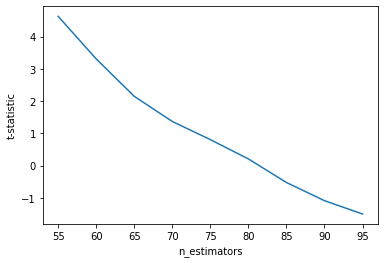

In [51]:
# Переобучить с шагом по деревьям 1
# 10 разбиений
# в каждом разбиении по 5 фолдов

t_stats, n_trees = [], []

for j in tqdm(range(50, 100, 1)):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_val_score(
            estimator=xgb.XGBRegressor(n_estimators=j, n_jobs=1),
            X=data[numerical_features],
            y=data["y"],
            scoring='r2',
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = ttest_rel(current_score, base_score)
    t_stats.append(t_stat)
    n_trees.append(j)

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

## Опасность переобучения на выбросы

Мы делаем кросс-валидацию снова и снова, выбирая только те модели, которые лучше работают на тестовых фолдах. И даже если мы периодически меняем `random_state` у `KFold`, делая тем самым фолды различными, они все равно, в конечном итоге, собираются из объектов обучающей выборки. И, улучшая решение, мы натаскиваете алгоритм именно на этих объектах. Если данные хорошие, и мы все делали аккуратно, то это может привести к тому, что алгоритм будет работать чуть лучше и на новых объектах, но одинакового перформанса в общем случае ждать не стоит. А в случае, когда данные достаточно шумные, есть риск столкнуться с неприятной ситуацией, что нам не на чем проверить работу алгоритма, кроме публичного лидерборда.

Поэтому, очень хорошей рекомендацией будет - иметь отложенную выборку. Я бы предложил делать так: получили задачу — сразу сделали отложенную выборку и выкинули ее из обучающей выборки. Посчитали, какой результат дает бейзлайн на этой выборке. Потом можно долго и упорно улучшать модель и наконец, когда уже самая лучшая модель готова, пришло время посмотреть качество на отложенной выборке. В случае kaggle роль отложенной выборки может играть паблик лидерборд. Но важно помнить, что чем чаще мы смотрим скор по отложенной выборке, тем хуже он оценивает качество модели на новых данных.

In [53]:
r2_score(
    [1,   2,    3,   4,   5,   11],
    [1.1, 1.96, 3.1, 4.5, 4.8, 5.3]
)

0.48208000000000006

In [54]:
# заменим первое предсказание на истонное значение
r2_score(
    [1,   2,    3,   4,   5,   11],
    [1, 1.96, 3.1, 4.5, 4.8, 5.3]
)

0.4822378947368421

In [55]:
# заменим последнее предсказание на 0.1
r2_score(
    [1,   2,    3,   4,   5,e   11],
    [1, 1.96, 3.1, 4.5, 4.8, 5.4]
)

0.5000800000000001

Обратите внимание на то, что если мы, например, вместо 1.1 во втором массиве напишем 1.0, скор изменится в четвертом знаке. А теперь попробуем подобраться на 0.1 ближе к нашему выбросу — заменим 5.3 на 5.4. Скор меняется сразу на 0.015, то есть примерно в 100 раз сильнее, чем если бы мы на столько же улучшили предсказание «нормального» значения. Таким образом, скор в основном определяется не тем, насколько точно мы предсказываем «нормальные» значения, а тем, какая из моделей случайно оказалась чуть лучше на выбросах. И становится понятно, что отбирая признаки и настраивая гиперпараметры, мы непроизвольно выбираем те модели, которые чуть лучше угадывают выбросы на тестовых фолдах, а не те, которые лучше предсказывают основную массу объектов. Это происходит просто потому, что модели, угадывающие аутлаеров, получают более высокий скор, а перформанс на основной массе объектов не очень сильно влияет на скор. 

В большинстве задач, выбросы предсказать невозможно. А если скоро мы не можем их предсказать, давайте и не учитывать их при сравнении моделей. Действительно, если любая из наших моделей одинаково плохо будет предсказывать выбросы на новых данных, какой смысл тогда оценивать предсказания выбросов на кросс-валидации? Есть две стратегии поведения в таких ситуациях:

* Давайте удалим все выбросы из обучающей выборки и только после этого будем обучать и валидировать модели. О том, как именно удалять выбросы, поговорим чуть позже, пока считаем, что как-то мы это делать умеем. Такая стратегия действительно очень сильная, единственная проблема этого метода состоит в том, что зачастую выкидывание аутлаеров смещает среднее предсказание, и мы вынуждены это смещение как-то компенсировать.

2. Не будем ничего удалять из обучающей выборки, но при валидации (при вычислении значения метрики на тестовых фолдах) не будем учитывать выбросы. Еще раз, все вплоть до вызова метода fit (и включая его) мы делаем, ничего не выкидывая, затем мы делаем predict на тестовых фолдах, но метрику считаем только на объектах, не являющихся выбросами.

In [60]:
def make_modify_cross_validation(X: pd.DataFrame,
                                 y: pd.Series,
                                 estimator: object,
                                 metric: callable,
                                 cv_strategy,
                                 error_to_be_outlier: None):
    """
    Кросс-валидация с учетом выбросов.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        if not error_to_be_outlier:
            fold_valid_scores.append(metric(y_valid, y_valid_pred))
        else:
            mask = ((y_valid - y_valid_pred) / y_valid) < error_to_be_outlier
            fold_valid_scores.append(metric(y_valid.loc[mask], y_valid_pred[mask]))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    if not error_to_be_outlier:
        oof_score = metric(y, oof_predictions)
    else:
        mask = ((y - oof_predictions) / y) < error_to_be_outlier
        oof_score = metric(y.loc[mask], oof_predictions[mask])

    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [67]:
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_modify_cross_validation(
    data[numerical_features], data["y"], model, metric=r2_score, cv_strategy=cv_strategy, error_to_be_outlier=0.05
)

[19:54:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 1, train-observations = 3367, valid-observations = 842
train-score = 0.5888, valid-score = 0.8535
[19:54:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 2, train-observations = 3367, valid-observations = 842
train-score = 0.6491, valid-score = 0.8358
[19:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 3, train-observations = 3367, valid-observations = 842
train-score = 0.6017, valid-score = 0.8262
[19:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 4, train-observations = 3367, valid-observations = 842
train-score = 0.6094, valid-score = 0.8245
[19:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold

## Валидация в задачах с привязкой ко времени

<img src="images/web2_timekfold.png" width=800 height=600 />

In [93]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit()
cv.split?

In [101]:
from sklearn.model_selection import GroupKFold
cv = GroupKFold(n_splits=5)
for train_idx, valid_idx in cv.split(data, data["y"], groups=data["X5"]):
    x_train = data.loc[train_idx]
    x_valid = data.loc[valid_idx]
    break

In [107]:
set(x_train["X5"].unique()) & (set(x_valid["X5"].unique()))

set()

In [ ]:
# Пример: прогнозирования мошенничества по банковским транзакциям
# Данные по времени: 1.09.2019 - 31.12.2019
# ID_transaction | ID_client | transaction_date

# Валидация по клиенту
# GroupKFold

## Что делать, если распределение на train / test разное

__Adversarial validation__

In [128]:
from sklearn.metrics import roc_auc_score

In [121]:
x_adv = pd.concat([
    x_train, x_valid], axis=0)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(x_valid.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [122]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv[numerical_features], y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [135]:
y_pred = model.predict_proba(x_train[numerical_features])
#roc_auc_score()

In [136]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]       0
(0.1, 0.2]     930
(0.2, 0.3]    2323
(0.3, 0.4]      87
(0.4, 0.5]       7
(0.5, 0.6]       0
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
dtype: int64